# MENuS
## Using Machine Learning to select the best solver
* Calculate the labels
* Include the ingredients generator.
    * Generate an Instance of Ingredients list.
* Finish the model.
* Use minizinc from python.
    * Run it with 3 Algorithms.
    * Add the Instance to the Instances List.
    * Add the time it takes for each Algorithm to the Time Execution Matrix.
    * Transform the Instances List into the Features Array.
    * Travel through the Time Execution Matrix and pick the Algorithms with faster results for each Instance.
    * The Algorithm with the fastest result will be added to the Labels list.

|  | Alg1 | Alg2 | Alg3 |
| --- | --- | --- | --- |
| Ins1 | X | Y | Z |
| Ins2 | X | Y | Z |
| Ins3 | X | Y | Z |
   
* Transform the ingredients list into the dataset for machine learning.
    * Create the Ingredients list.
    * Test with the minizinc model, all the Alg = 3 -> minizinc(300).
    * Take and transform the one that takes less time.
* Training the AI. Split dataset, 70% for training and 30% for prediction, at least 80% accuracy expected. 
----------------------------------------------------------------------------------------------------------

### Auxiliar Functions

In [25]:
def print_red(text):
    print('\x1b[31m' + text + '\x1b[0m')
    
def print_yellow(text):
    print('\x1b[33m' + text + '\x1b[0m')

def print_green(text):
    print('\x1b[32m' + text + '\x1b[0m')

def print_pink(text):
    print('\x1b[35m' + text + '\x1b[0m')

def print_cyan(text):
    print('\x1b[36m' + text + '\x1b[0m')

## Get the Instances
The instances have been generated using the notebook: Generate Instance.ipynb

In [26]:
import os

instances_folder = '../datasets/i5_200_1_1000'
instances_path = [os.path.join(instances_folder, f) for f in os.listdir(instances_folder) if f.endswith('.dzn')]
instances = []
labels_txt = ''
for path in instances_path:
    with open(path, encoding="utf8") as file_object:
        instances.append(file_object.read())
        
with open(instances_folder+'/labels.txt', encoding="utf8") as file_object:
        labels_txt = file_object.read()
#print(instances_path)
print(labels_txt)

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]


# Machine Learning
## Get data: Parse instances to features.

In [27]:
import numpy as np

# Ingredients list
def get_groceries(g_array):
    data_groceries = []
    for i in range(0, len(g_array)):
        loop_groceries = g_array[i].split("groceries = [|")
        loop_groceries = loop_groceries[1].split("|];\nrequirements")
        loop_groceries = loop_groceries[0].split("|")
        
        for j in range(0, len(loop_groceries)):
            # Conversion from String to Int Array.
            loop_groceries[j] = [int(x) for x in loop_groceries[j].split(",")]
            
        data_groceries = data_groceries + [np.array(loop_groceries)]
    return data_groceries

def get_requirements(r_array):
    data_requirements = []
    for i in range(0, len(r_array)):
        loop_requirements = r_array[i].split("requirements = [|")
        loop_requirements = loop_requirements[1].split("|];")
        loop_requirements = loop_requirements[0].split("|")
        
        for j in range(0, len(loop_requirements)):
            # Conversion from String to Int Array.
            loop_requirements[j] = [int(x) for x in loop_requirements[j].split(",")]
            
        data_requirements = data_requirements + [np.array(loop_requirements)]
    return data_requirements


def create_features(instances):
    q_features = 31
    res = np.zeros((len(instances), q_features))    
    np_groceries = get_groceries(instances)
    np_requirements = get_requirements(instances)
    # print(np_groceries[0])
    # print(np_requirements[0])
    
    for i in range(0,len(instances)):
        # features: i in the left represents an Instance; 0,1... in the right represents a Feature.
        #----------------------------------------------------
        # np_groceries: i in the left represents an Instance; ":" represents all rows; 0,1... in the right represents a Macronutrient Column.
        # 0: Calories. 1: Protein. 2: Carbo. 3: Fat. 4: Quantity. 5: Price.
        """res[i,0] = np.mean(np_groceries[i][:,0])
        res[i,1] = np.median(np_groceries[i][:,0])
        res[i,2] = np.std(np_groceries[i][:,0])
        res[i,3] = np.var(np_groceries[i][:,0])
        res[i,4] = np.min(np_groceries[i][:,0])
        res[i,5] = np.max(np_groceries[i][:,0])
        res[i,6] = np.argmin(np_groceries[i][:,0])
        res[i,7] = np.argmax(np_groceries[i][:,0])
        res[i,8] = np.percentile(np_groceries[i][:,0],25)
        res[i,9] = np.percentile(np_groceries[i][:,0],75)"""
        #----------------------------------------------------
        res[i,0] = np.mean(np_groceries[i][:,1])
        res[i,1] = np.median(np_groceries[i][:,1])
        res[i,2] = np.std(np_groceries[i][:,1])
        res[i,3] = np.var(np_groceries[i][:,1])
        res[i,4] = np.min(np_groceries[i][:,1])
        res[i,5] = np.max(np_groceries[i][:,1])
        res[i,6] = np.argmin(np_groceries[i][:,1])
        res[i,7] = np.argmax(np_groceries[i][:,1])
        res[i,8] = np.percentile(np_groceries[i][:,1],25)
        res[i,9] = np.percentile(np_groceries[i][:,1],75)
        #----------------------------------------------------
        res[i,10] = np.mean(np_groceries[i][:,2])
        res[i,11] = np.median(np_groceries[i][:,2])
        res[i,12] = np.std(np_groceries[i][:,2])
        res[i,13] = np.var(np_groceries[i][:,2])
        res[i,14] = np.min(np_groceries[i][:,2])
        res[i,15] = np.max(np_groceries[i][:,2])
        res[i,16] = np.argmin(np_groceries[i][:,2])
        res[i,17] = np.argmax(np_groceries[i][:,2])
        res[i,18] = np.percentile(np_groceries[i][:,2],25)
        res[i,19] = np.percentile(np_groceries[i][:,2],75)                
        #----------------------------------------------------
        res[i,20] = np.mean(np_groceries[i][:,3])
        res[i,21] = np.median(np_groceries[i][:,3])
        res[i,22] = np.std(np_groceries[i][:,3])
        res[i,23] = np.var(np_groceries[i][:,3])
        res[i,24] = np.min(np_groceries[i][:,3])
        res[i,25] = np.max(np_groceries[i][:,3])
        res[i,26] = np.argmin(np_groceries[i][:,3])
        res[i,27] = np.argmax(np_groceries[i][:,3])
        res[i,28] = np.percentile(np_groceries[i][:,3],25)
        res[i,29] = np.percentile(np_groceries[i][:,3],75)
        #---------------------------------------------------
        # np_requirements: i in the left represents an Instance; ":" represents all rows; 0,1... in the right represents a Macronutrient Column.
        # 0: Calories. 1: Protein. 2: Carbo. 3: Fat. 4: Quantity. 5: Price.
        #---------------------------------------------------
        res[i,30] = len(np_groceries[i])
        
    return res

## Create Labels and Features.
Represents the solver that solved the model in the best way, comparing first the result and then the time. The best solver will be the one that solves the model with a minor value in less time.

In [28]:
features = create_features(instances)
import ast
labels = ast.literal_eval(labels_txt)
print(labels)

#labels = solve_with_minizinc(instances_path, 10, 15)

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]


## Algorithms

In [29]:
X = features # Features
y = labels # Labels

# Normalize the data to have zero mean and unit variance
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = np.where(std == 0, 0, (X - mean) / std)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train a machine learning model on the training set
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model on the testing set
accuracy = model.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.6


In [30]:
# Train a machine learning model on the training set
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=10, random_state=0)
model.fit(X_train, y_train)

# Evaluate the model on the testing set
accuracy = model.score(X_test, y_test)
# Predict labels for the test set
y_pred = model.predict(X_test)

print('Accuracy:', accuracy)

Accuracy: 0.625


## Confusion Matrix

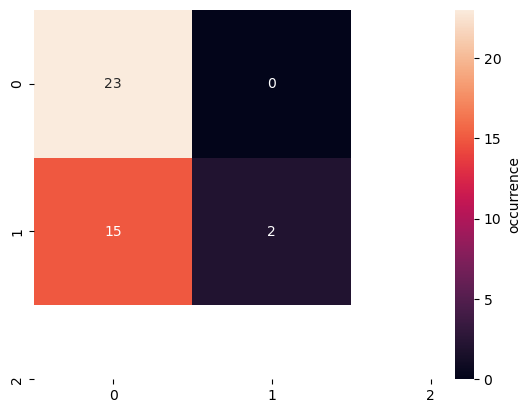

In [31]:
from sklearn.metrics import confusion_matrix
# create confusion matrix
cm = confusion_matrix(y_test, y_pred)
# print confusion matrix
# print(cm)
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, cbar_kws={"orientation": "vertical", "label": "occurrence"}, xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.show()

In [32]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)


[0 1 2]
[105  54   1]


In [33]:
freq = {}

# Count frequency of each element in the array
for num in labels:
    if num in freq:
        freq[num] += 1
    else:
        freq[num] = 1

# Print frequency of each element
for num, count in freq.items():
    print(f"{num}: {count} {count/len(labels)*100}%")


0: 128 64.0%
1: 71 35.5%
2: 1 0.5%
